![image](https://www.ewatercycle.org/assets/logo.png)

# Case study 0: Hello worlds. Run two models on the same forcing data and compare output (discharge)
This notebooks demonstrates how to use models in eWaterCycle by showing how to run two different models for the same region (Merrimack) and on the same forcing data (ERA5: 1990).

The models used in this notebook are:

- WFlow (details)
- LISFLood (details)

## Import statements
We'll be using the following modules

In [1]:
import logging
logger = logging.getLogger('grpc4bmi.bmi_grpc_client')
logger.setLevel(logging.WARNING)

In [19]:
import os
from cftime import num2date
import pandas as pd
import xarray as xr
from pathlib import Path

from ewatercycle import CFG
from ewatercycle.models import Wflow
from ewatercycle.models import Lisflood
from ewatercycle.analysis import hydrograph
from ewatercycle.observation.grdc import get_grdc_data
from ewatercycle.models.lisflood import LisfloodParameterSet

In [3]:
CFG.load_from_file('./ewatercycle.yaml')

## Wflow

In [4]:
# create wflow instance
model = Wflow()

cfg_file, cfg_dir = model.setup(
    cfg_dir='/projects/0/wtrcycle/comparison/wflow_parameterset/calibrated_parameterset/merrimack/',
    cfg_file='./wflow_sbm_Merrimack_ERA5_warmup.ini',
    API={"RiverRunoff": "2, m^3/s"}
)
print(cfg_dir)

Working directory created: /scratch/shared/ewatercycle/wflow_20210422_092136
Created /scratch/shared/ewatercycle/wflow_20210422_092136/wflow_ewatercycle.ini.
Running ewatercycle-wflow-grpc4bmi.sif singularity container on port 36962
Started wflow container with working directory /scratch/shared/ewatercycle/wflow_20210422_092136
/scratch/shared/ewatercycle/wflow_20210422_092136


In [6]:
# initialize
model.initialize(str(cfg_file))

# get metadata
print(model.output_var_names)

('RiverRunoff',)


In [7]:
discharge = []
while model.time <= model.end_time:
    model.update()
    discharge.append(model.get_value_as_xarray('RiverRunoff'))
    
wflow_output = xr.concat(discharge, dim='time')

In [8]:
wflow_output

<xarray.DataArray 'RiverRunoff' (time: 365, latitude: 242, longitude: 154)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * longitude  (longitude) float64 -72.14 -72.13 -72.12 ... -70.88 -70.87 -70.86
  * latitude   (latitude) float64 42.2 42.21 42.22 42.23 ... 44.2 44.2 44.21
  * time       (time) object 1990-01-01 12:00:00 ... 1990-12-31 12:00:00
Attributes:
    units:     m^3/s

In [9]:
# stop the model
model.finalize()
del(model)

## Lisflood

In [10]:
parameterset = LisfloodParameterSet(
    root=Path('/projects/0/wtrcycle/comparison/lisflood_input/Lisflood01degree_masked'),
    mask=Path('/projects/0/wtrcycle/comparison/recipes_auxiliary_datasets/LISFLOOD/model_mask.nc'),
    config_template=Path('/projects/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisflood.xml'),
    lisvap_config_template=Path('/projects/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisvap.xml'),
)

In [11]:
# create lisflood instance
model = Lisflood()

# setup model
# lisflood_ERA5_*_1990_1990.nc data can be copied 
# from /projects/0/wtrcycle/comparison/forcing/lisflood
forcing_dir = Path('lisflood_forcing_data')
config_file, config_dir = model.setup(forcing_dir, parameterset)
print(config_dir)

# run lisvap
# lisvap_results = model.run_lisvap(forcing_dir)

Running ewatercycle-lisflood-grpc4bmi.sif singularity container on port 45491
/scratch/shared/ewatercycle/lisflood_20210422_092826


In [12]:
# initialize
model.initialize(str(config_file))

# get metadata
print(model.output_var_names)

('Discharge',)


In [13]:
# run the model
discharge = []
while model.time <= model.end_time:
    model.update()
    discharge.append(model.get_value_as_xarray('Discharge'))

lisflood_output = xr.concat(discharge, dim='time')

In [14]:
lisflood_output

<xarray.DataArray 'Discharge' (time: 363, latitude: 1500, longitude: 3600)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.8 -179.8 ... 179.7 179.8 179.9
  * latitude   (latitude) float64 89.95 89.85 89.75 ... -59.75 -59.85 -59.95
  * time       (time) object 1990-01-03 00:00:00 ... 1990-12-31 00:00:00
Attributes:
    units:    m^3/s

In [15]:
# Get time information
start = num2date(model.start_time, model.time_units).strftime("%Y-%m-%d")
end = num2date(model.end_time, model.time_units).strftime("%Y-%m-%d")

In [16]:
# stop the model
del model.bmi

## Observation

In [66]:
# Setting GRDC_DATA_HOME so that `get_grdc_data` can find them:
os.environ["GRDC_DATA_HOME"] = str("/projects/0/wtrcycle/comparison/GRDC/GRDC_GCOSGTN-H_27_03_2019")

# Get grdc observations
ds = get_grdc_data("4147380", start, end)
ds["time"] = ds["time"].dt.strftime('%Y-%m-%d')
observations = ds.to_dataframe().rename(columns={"streamflow": "GRDC"})

station_lat = ds.attrs["grdc_latitude_in_arc_degree"]
station_lon = ds.attrs["grdc_longitude_in_arc_degree"]

## Get the simulated discharge value at one location

### wflow: geuss outlet point

In [67]:
# Find the gridpoint nearby (lat, lon) that's most likely a river
pad=0.2
box = wflow_output.sel(
    longitude=slice(station_lon - pad, station_lon + pad),
    latitude=slice(station_lat - pad, station_lat + pad),
)
wflow_discharge = box.max(["longitude", "latitude"])
wflow_discharge["time"] = wflow_discharge["time"].dt.strftime('%Y-%m-%d')
wflow_discharge = wflow_discharge.to_dataframe().rename(columns={"RiverRunoff": "wflow"})

### lisflood: select a pixel 

In [68]:
# pixel indices (1086, 473) related to Merrimack given by lisflood modelers
lisflood_discharge = lisflood_output.isel(dict(longitude=1086, latitude=473))
lisflood_discharge["time"] = lisflood_discharge["time"].dt.strftime('%Y-%m-%d')
lisflood_discharge = lisflood_discharge.to_dataframe().rename(columns={"Discharge": "lisflood"})
lisflood_discharge = lisflood_discharge.drop(['longitude','latitude'], axis=1)

## Hydrograph

/home/fakhereh/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [0] contained NaN values and the row(s) have been removed (Rows are zero indexed).
/home/fakhereh/miniconda3/envs/ewatercycle/lib/python3.9/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [0 1] contained NaN values and the row(s) have been removed (Rows are zero indexed).


(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

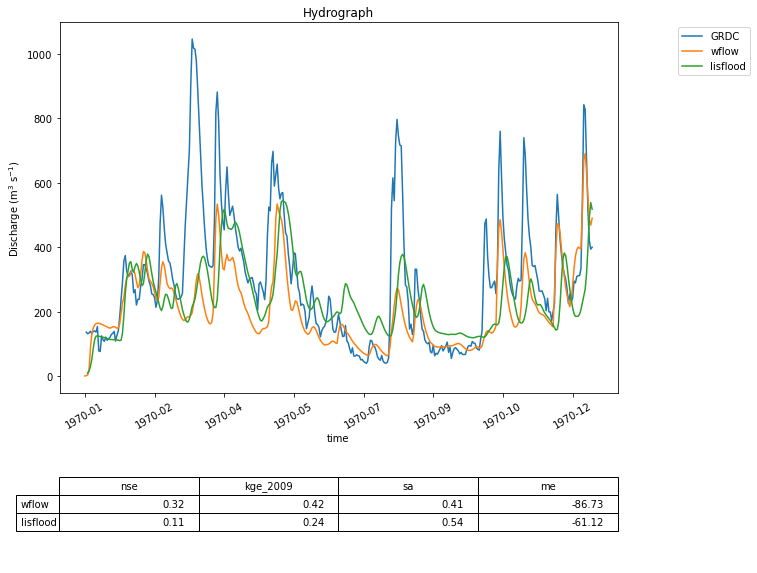

In [69]:
hydro_data = pd.concat([wflow_discharge, lisflood_discharge, observations], axis=1, sort=False)
hydrograph(hydro_data, reference='GRDC')

In [70]:
hydro_data

,wflow,lisflood,GRDC
time,,,
1990-01-01,0.285482,NaN,NaN
1990-01-02,1.273368,NaN,136.204
1990-01-03,3.413502,9.061750,131.107
1990-01-04,19.958593,15.274644,133.655
1990-01-05,86.438278,30.082788,139.035
...,...,...,...
1990-12-27,631.879700,318.036922,668.276
1990-12-28,552.051636,398.285179,512.534
1990-12-29,484.896515,491.402610,419.089
